In [47]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline

import torchvision as tv
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

### FashionMNIST.

In [48]:
BATCH_SIZE = 256

In [49]:
train_dataset = tv.datasets.FashionMNIST('.', train=True, transform=tv.transforms.ToTensor(), download=True)
test_dataset  = tv.datasets.FashionMNIST('.', train=False, transform=tv.transforms.ToTensor(), download=True)
train = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

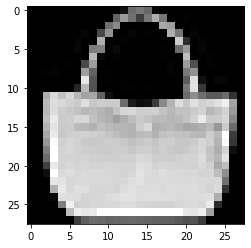

In [50]:
plt.imshow(train_dataset[100][0].numpy().reshape(28, 28), cmap='gray')

In [51]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

### Сверточные слои и архитектура

In [52]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"); dev

device(type='cuda')

In [53]:
def evaluate(model, test_iter, dev):    
    model.eval()
    with torch.no_grad():
        acc_sum = 0
        count = 0
        for X, y in test_iter:
            X, y = X.to(dev), y.to(dev)
            acc_sum += (model(X).argmax(axis=1) == y).sum().item()
            count += y.shape[0]
        return acc_sum / count

In [54]:
def train_net(train_iter, test_iter, model, epochs, trainer):
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = model.to(dev)
    
    loss = nn.CrossEntropyLoss(reduction='sum')
    
    for epoch in range(1, epochs + 1):
        train_loss_sum, train_acc_sum, count, start = 0.0, 0.0, 0, time.time()
        
        model.train()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(dev), y.to(dev)
            predict = model(X)
            l = loss(predict, y)
            l.backward()
            trainer.step()
            train_loss_sum += l.item()
            train_acc_sum += (predict.argmax(axis=1) == y).sum().item()
            count += y.shape[0]
                        
        train_acc = train_acc_sum / count
        train_loss  = train_loss_sum / count
        test_acc = evaluate(model, test_iter, dev)
        run = time.time() - start
        
        print(f"epoch = {epoch}, train_acc = {train_acc:.7f}, train_loss = {train_loss:.7f}, test_acc = {test_acc:.7f}, time = {run:.7f}")
            
    

In [88]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=2, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(32, 64, kernel_size=2, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(64, 64, kernel_size=3, padding=2),
    nn.ReLU(),
    nn.MaxPool2d( 2, stride=2),
    nn.Conv2d(64, 32, kernel_size=3, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(288, 288),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(288, 72),
    nn.BatchNorm1d(72),
    nn.ReLU(),
    nn.Linear(72, 10),
    
)

In [89]:
def test_shape(model, X):
    X = X.reshape(1, 1, 28, 28)
    print(X.shape)
    for l in model:
        try:
            X = l(X)
        except Exception as ex: 
            print('--------', ex) # при проверке shape, BatchNorm выдает ошибку, но в сети работает
        print("Layer {}. X shape: {}".format(l, X.shape))

test_shape(model, train_dataset[0][0])

torch.Size([1, 1, 28, 28])
Layer Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1)). X shape: torch.Size([1, 32, 29, 29])
Layer ReLU(). X shape: torch.Size([1, 32, 29, 29])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 32, 14, 14])
Layer Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 64, 17, 17])
Layer ReLU(). X shape: torch.Size([1, 64, 17, 17])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 64, 8, 8])
Layer Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 64, 10, 10])
Layer ReLU(). X shape: torch.Size([1, 64, 10, 10])
Layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False). X shape: torch.Size([1, 64, 5, 5])
Layer Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)). X shape: torch.Size([1, 32, 7, 7])
Layer ReLU(). X shape: torch.S

In [90]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"); dev
model.to(dev)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten()
  (13): Linear(in_features=288, out_features=288, bias=True)
  (14): Dropout(p=0.5, inplace=False)
  (15): ReLU()
  (16): Linear(in_features=288, out_features=72, bias=True)
  (17): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (18): ReLU()
  (19): Linear(i

In [91]:
epochs = 20
learing_rate = 0.0003
trainer = torch.optim.AdamW(model.parameters(), lr=learing_rate)

In [92]:
train_net(train, test, model, epochs, trainer)

epoch = 1, train_acc = 0.6895167, train_loss = 1.0424221, test_acc = 0.8153000, time = 6.2749248
epoch = 2, train_acc = 0.8457333, train_loss = 0.4840154, test_acc = 0.8557000, time = 6.2149146
epoch = 3, train_acc = 0.8732833, train_loss = 0.3725885, test_acc = 0.8799000, time = 6.2625146
epoch = 4, train_acc = 0.8890833, train_loss = 0.3213399, test_acc = 0.8904000, time = 6.3999116
epoch = 5, train_acc = 0.8976333, train_loss = 0.2896515, test_acc = 0.8940000, time = 6.3853624
epoch = 6, train_acc = 0.9052167, train_loss = 0.2681109, test_acc = 0.8969000, time = 6.4377809
epoch = 7, train_acc = 0.9116500, train_loss = 0.2498018, test_acc = 0.9082000, time = 6.4530864
epoch = 8, train_acc = 0.9166500, train_loss = 0.2360191, test_acc = 0.9053000, time = 6.3488133
epoch = 9, train_acc = 0.9198833, train_loss = 0.2254239, test_acc = 0.9088000, time = 6.3597789
epoch = 10, train_acc = 0.9240833, train_loss = 0.2145508, test_acc = 0.9076000, time = 6.4247615
epoch = 11, train_acc = 0.927